In [1]:
import numpy as np
import emcee
from matplotlib import pyplot as plt
from operator import itemgetter
from scipy.stats import uniform, norm
from scipy.integrate import quad, simps
from scipy.interpolate import interp1d
from functools import reduce
from os.path import join, abspath
from os import pardir, mkdir
import sys
import vaex

In [2]:
# import utils
root_dir = abspath(pardir)
root_dir

'/home2/s20321005/Thesis-Project'

In [3]:
if root_dir not in sys.path:
    sys.path.append(root_dir)
sys.path

['/home2/s20321005/Thesis-Project/4_Gravity',
 '/home2/s20321005/.conda/envs/vaex/lib/python38.zip',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/lib-dynload',
 '',
 '/home2/s20321005/.local/lib/python3.8/site-packages',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/site-packages',
 '/home2/s20321005/Thesis-Project']

In [4]:
from utils import nu_mod

In [5]:
root_data_dir = abspath(join(root_dir, "Data"))
root_data_dir

'/home2/s20321005/Thesis-Project/Data'

In [6]:
data_baryon_dir = join(root_data_dir, "Baryon")
data_velocity_dir = join(root_data_dir, "Velocity-Distribution")
data_eff_dir = join(root_data_dir, "Effective-Volume")

In [7]:
# load baryons components
df_baryon = vaex.open(join(data_baryon_dir, "baryon.hdf5"))
df_baryon

#,components,rho,e_rho,sigma_z,e_sigma_z
0,Molecular gas (H2),0.0104,0.00312,3.7,0.2
1,Cold atomic gas (HI(1)),0.0277,0.00554,7.1,0.5
2,Warm atomic gas (HI(2)),0.0073,0.0007,22.1,2.4
3,Hot ionized gas (HII),0.0005,3e-05,39.0,4.0
4,Giant stars,0.0006,6e-05,15.5,1.6
...,...,...,...,...,...
7,4 < MV < 5,0.0029,0.00029,18.0,1.8
8,5 < MV < 8,0.0072,0.00072,18.5,1.9
9,MV > 8,0.0216,0.0028,18.5,4.0
10,White dwarfs,0.0056,0.001,20.0,5.0


# Math

let $Z=\{z_i\}$ is a collection of vertical positions of the stars, and $W=\{w_i\}$ is a collection of vertical velocities of the stars. We assume that the vertical positions and velocities are independent. $Z$ and $W$ are inhomogeneous Poisson processes with intensity $\lambda(z)$ and $\mu(w)$ respectively. The intensity $\lambda(z)$ is the number density of star in vertical direction, and $\mu(w)$ is the number density of stars at some velocity $w$.

From previous notebook, the intensity $\lambda(z)$ can be calculated depent on the following parameters $\theta$:
* $\rho_{i}$ - the density of the baryons
* $\sigma_{z,i}$ - baryons velocity dispersion in vertical direction
* $\rho_{\text{DM}}$ - the density of the dark matter halo in the vicinity of the sun
* $\Sigma_{\text{DD}}$ - surface density of dark disk
* $h_{\text{DD}}$ - the vertical scale height of dark disk
* $\nu_0$ - the number density of stars in the midplane disk
* $z_{\odot}$ - the position of the sun
* $R$ - Oort constant radial contribution
* $\sigma_w$ - the velocity dispersion of the stars in vertical direction
* $w_0$ - the velocity of the sun

So,
\begin{aligned}
  \lambda (z) &= f(z;\theta) \\
  &= \nu(z;\theta) \mathcal{F} (z) \\
  &= \nu_0 \exp \left[ -\frac{\Phi(z+z_{\odot};\rho_i,\sigma_{z,i}, \rho_{\text{DM}}, \Sigma_{\text{DD}}, h_{\text{DD}}, R )}{\sigma_w^2} \right] \mathcal{F} (z)\\
\end{aligned}

Where $\mathcal{F} (z)$ is the completeness function

and the same goes for the intensity $\mu(w)$:
\begin{aligned}
  \mu (w) &= g(w;\theta) \\
  &= N_0\mathcal{N}(w;\sigma_w, w_0)
\end{aligned}

Where $N_0$ is the normalization constant

# Framework

by using Bayesian Statistics, we can calculate the posterior distribution of the parameters $\theta$ given the data $Z$ and $W$:
\begin{aligned}
  p_\text{pos}(\theta|Z,W) &= \frac{p_\text{like}(Z,W|\theta)p_\text{prior}(\theta)}{p_\text{ev}(Z,W)} \\
  &\propto p_\text{like,Z}(Z|\theta)p_\text{like,W}(W|\theta) p_0(\theta) \\
  &\propto \mathcal{L}_z(Z|\theta)\mathcal{L}_w(W|\theta) p_0(\theta) \\
  \text{log } p_\text{pos}(\theta|Z,W) &= \text{log } \mathcal{L}_z(Z|\theta) + \text{log } \mathcal{L}_w(W|\theta) + \text{log } p_0(\theta) + C\\
\end{aligned}

Where the likelihood is the likelihood of inhomogeneous Poisson process,
\begin{aligned}
  \text{log } \mathcal{L}_z(Z|\theta) &= \sum_i \log \lambda(z_i) - \int \lambda(z) \text{ d}z \\
  \text{log } \mathcal{L}_w(W|\theta) &= \sum_i \log \mu(w_i) - \int \mu(w) \text{ d}w \\
\end{aligned}

### Prior

Either we can use a uniform prior or a Gaussian prior. The uniform prior is represented by [lower, upper].
| Parameter | Prior | Description |
| --- | --- | --- |
| $\rho_{i}$ | Gaussian | Check the baryons table |
| $\sigma_{z,i}$ | Gaussian | Check the baryons table |
| $\rho_{\text{DM}}$ | [0, 0.06] msun/pc^3 |  |
| $\Sigma_{\text{DD}}$ | [0, 30] msun/pc^2 | |
| $h_{\text{DD}}$ | [0, 100] pc |  |
| $\text{log }\nu_0$ | [12, 13] | A star (star/kpc^3) |
|  | [14, 14.4] | F star |
|  | [13.8, 14] | G star |
| $z_{\odot}$ | [-50, 50] pc | |
| $R$ | Gaussian | mean=3.4E-3, std=0.6E-3 in msun/pc^3|
| $\sigma_w$ | [1, 20] km/s | |
| $w_0$ | [-20, 20] km/s | |

In [7]:
def log_prior(theta, locs, scales):
    args = ('rhos', 'sigmaz', 'rhoDM', 'sigmaDD', 'hDD', 'Nu0', 'zsun', 'R', 'sigma_w', 'w0', 'N0')
    rhos, sigmaz, rhoDM, sigmaDD, hDD, Nu0, zsun, R, sigma_w, w0, N0 = itemgetter(*args)(theta)
    args = ('rhos_loc', 'sigmaz_loc', 'rhoDM_loc', 'sigmaDD_loc',  'hDD_loc', 'Nu0_loc', 
            'zsun_loc', 'R_loc', 'sigma_w_loc', 'w0_loc', 'N0_loc')
    rhos_loc, sigmaz_loc, rhoDM_loc, sigmaDD_loc, hDD_loc, Nu0_loc, zsun_loc, R_loc, sigma_w_loc, w0_loc, N0_loc = itemgetter(*args)(locs)
    args = ('rhos_scale', 'sigmaz_scale', 'rhoDM_scale', 'sigmaDD_scale', 'hDD_scale', 'Nu0_scale',
            'zsun_scale', 'R_scale', 'sigma_w_scale', 'w0_scale', 'N0_scale')
    rhos_scale, sigmaz_scale, rhoDM_scale, sigmaDD_scale, hDD_scale, Nu0_scale, zsun_scale, R_scale, sigma_w_scale, w0_scale, N0_scale = itemgetter(*args)(scales)
    uni_loc = np.array([rhoDM_loc, sigmaDD_loc, hDD_loc, Nu0_loc, zsun_loc, sigma_w_loc, w0_loc, N0_loc])
    uni_scale = np.array([rhoDM_scale, sigmaDD_scale, hDD_scale, Nu0_scale, zsun_scale, sigma_w_scale, w0_scale, N0_scale])
    uni_val = rhoDM, sigmaDD, hDD, Nu0, zsun, sigma_w, w0, N0
    log_uni = np.sum(uniform.logpdf(uni_val, loc=uni_loc, scale=uni_scale))
    result = (np.sum(norm.logpdf(rhos, loc=rhos_loc, scale=rhos_scale))
            +np.sum(norm.logpdf(sigmaz, loc=sigmaz_loc, scale=sigmaz_scale))
            +norm.logpdf(R, loc=R_loc, scale=R_scale)
            +log_uni)
    return result

In [9]:
# test log_prior
rhos = df_baryon['rho'].to_numpy()
e_rhos = df_baryon['e_rho'].to_numpy()
sigmaz = df_baryon['sigma_z'].to_numpy()
e_sigmaz = df_baryon['e_sigma_z'].to_numpy()

rhoDM = 0.016 # Msun/pc^3
sigmaDD = 7 # Msun/pc^2
zsun = 0 # pc
hDD = 65 # pc
Nu0 = 1500
zsun = 0.00 # pc
R = 3.4E-3 # Msun/pc^3
sigma_w = 5
w0 = -7
N0 = 178

theta = dict(rhos=rhos, sigmaz=sigmaz, rhoDM=rhoDM, sigmaDD=sigmaDD, hDD=hDD, Nu0=Nu0, zsun=zsun, R=R, sigma_w=sigma_w, w0=w0, N0=N0)

locs = dict(rhos_loc=rhos, sigmaz_loc=sigmaz, rhoDM_loc=0, sigmaDD_loc=0, hDD_loc=0, Nu0_loc=1000, zsun_loc=-0.05, R_loc=3.4E-3, sigma_w_loc=1, w0_loc=-20, N0_loc=50)
scales = dict(rhos_scale=e_rhos, sigmaz_scale=e_sigmaz, rhoDM_scale=0.06, sigmaDD_scale=30, hDD_scale=100, Nu0_scale=1000, zsun_scale=0.1, R_scale=0.6E-3, sigma_w_scale=19, w0_scale=40, N0_scale=200)

log_prior(theta, locs, scales)

46.26212889198277

In [12]:
import time

def log_likelihood(theta, z, w, comp_z):
    nu_f = lambda x: np.exp(log_nu_mod(x, theta))*comp_z(x)
    zz = np.linspace(np.min(z), np.max(z), 1000)  
    integral_nu = simps(nu_f(zz), zz)
    log_nu = np.sum(log_nu_mod(z, theta)+np.log(comp_z(z)))

    mu_f = lambda x: theta['N0']*norm.pdf(x, loc=theta['w0'], scale=theta['sigma_w'])
    integral_mu, _ = quad(mu_f, np.min(w), np.max(w))
    log_mu = np.sum(norm.logpdf(w, loc=theta['w0'], scale=theta['sigma_w'])+np.log(theta['N0']))
    return log_nu-integral_nu+log_mu-integral_mu

In [13]:
# Test likelihood

tipe = "A"

df_number = vaex.open(join(data_number_dir, f"cum-{tipe}.hdf5"))
df_velocity = vaex.open(join(data_velocity_dir, f"{tipe}-type.hdf5"))
df_comp = vaex.open(join(data_comp_dir, "comp.hdf5"))

z = df_number.z.to_numpy()
w = df_velocity.w.to_numpy()
comp = df_comp[tipe].to_numpy()
zz = df_comp.z.to_numpy()
comp_z = interp1d(zz, comp, kind='cubic', fill_value='extrapolate')

log_likelihood(theta, z, w, comp_z)

14568.542203152714

In [22]:
def log_posterior(x, priors, data, comp_z):
  theta = dict(rhos=x[0:12], sigmaz=x[12:24], rhoDM=x[24], sigmaDD=x[25], hDD=x[26], Nu0=x[27], zsun=x[28], R=x[29], sigma_w=x[30], w0=x[31], N0=x[32])
  locs, scales = itemgetter('locs', 'scales')(priors)
  z, w = itemgetter('z', 'w')(data)
  log_prior_ = log_prior(theta, locs, scales)
  if not np.isfinite(log_prior_):
      return -np.inf
  log_likelihood_ = log_likelihood(theta, z, w, comp_z)
  return log_prior_ + log_likelihood_

In [18]:
# Test posterior
x = np.array([*rhos, *sigmaz, rhoDM, sigmaDD, hDD, Nu0, zsun, R, sigma_w, w0, N0])
priors = dict(locs=locs, scales=scales)
data = dict(z=z, w=w)
log_posterior(x, priors, data, comp_z)

14614.804332044698

Save relevant functions in utils.py

### Test prior, likelihood, and posterior from utils.py

In [19]:
from utils import log_prior, log_likelihood, log_posterior

In [21]:
# Test values
# test log_prior
rhos = df_baryon['rho'].to_numpy()
e_rhos = df_baryon['e_rho'].to_numpy()
sigmaz = df_baryon['sigma_z'].to_numpy()
e_sigmaz = df_baryon['e_sigma_z'].to_numpy()

rhoDM = 0.016 # Msun/pc^3
sigmaDD = 7 # Msun/pc^2
zsun = 0 # pc
hDD = 65 # pc
Nu0 = 1500
zsun = 0.00 # pc
R = 3.4E-3 # Msun/pc^3
sigma_w = 5
w0 = -7
N0 = 178

theta = dict(rhos=rhos, sigmaz=sigmaz, rhoDM=rhoDM, sigmaDD=sigmaDD, hDD=hDD, Nu0=Nu0, zsun=zsun, R=R, sigma_w=sigma_w, w0=w0, N0=N0)

locs = dict(rhos_loc=rhos, sigmaz_loc=sigmaz, rhoDM_loc=0, sigmaDD_loc=0, hDD_loc=0, Nu0_loc=1000, zsun_loc=-0.05, R_loc=3.4E-3, sigma_w_loc=1, w0_loc=-20, N0_loc=50)
scales = dict(rhos_scale=e_rhos, sigmaz_scale=e_sigmaz, rhoDM_scale=0.06, sigmaDD_scale=30, hDD_scale=100, Nu0_scale=1000, zsun_scale=0.1, R_scale=0.6E-3, sigma_w_scale=19, w0_scale=40, N0_scale=200)

log_prior(theta, locs, scales)

46.26212889198277

In [23]:
tipe = "A"

df_number = vaex.open(join(data_number_dir, f"cum-{tipe}.hdf5"))
df_velocity = vaex.open(join(data_velocity_dir, f"{tipe}-type.hdf5"))
df_comp = vaex.open(join(data_comp_dir, "comp.hdf5"))

z = df_number.z.to_numpy()
w = df_velocity.w.to_numpy()
comp = df_comp[tipe].to_numpy()
zz = df_comp.z.to_numpy()
comp_z = interp1d(zz, comp, kind='cubic', fill_value='extrapolate')

log_likelihood(theta, z, w, comp_z)

14568.542203152714

In [34]:
len(z)

20345

In [25]:
x = np.array([*rhos, *sigmaz, rhoDM, sigmaDD, hDD, Nu0, zsun, R, sigma_w, w0, N0])
priors = dict(locs=locs, scales=scales)
data = dict(z=z, w=w)
log_posterior(x, priors, data, comp_z)

14614.804332044698

# MCMC

In [26]:
name = "MCMC"
data_dir_mcmc = join(root_data_dir, name)
try:
  mkdir(data_dir_mcmc)
  print(f"Creating {name} dir in Data dir")
except FileExistsError:
  print("Directory already exist. Good to go!")

Directory already exist. Good to go!


In [59]:
# example mcmc
# np.random.seed(42)
ndim = 33
nwalkers = ndim*2

tipe = "G"

rhos_0 = np.random.normal(loc=rhos, scale=e_rhos, size=(nwalkers, 12))
sigmaz_0 = np.random.normal(loc=sigmaz, scale=e_sigmaz, size=(nwalkers, 12))

rhoDM_loc, rhoDM_scale = 0, 0.06
rhoDM_0 = np.random.uniform(low=rhoDM_loc, high=rhoDM_loc+rhoDM_scale, size=nwalkers)

sigmaDD_loc, sigmaDD_scale = 0, 30
sigmaDD_0 = np.random.uniform(low=sigmaDD_loc, high=sigmaDD_loc+sigmaDD_scale, size=nwalkers)

hDD_loc, hDD_scale = 0, 100
hDD_0 = np.random.uniform(low=hDD_loc, high=hDD_loc+hDD_scale, size=nwalkers)


Nu0_loc, Nu0_scale = 20000, 80000
Nu0_0 = np.random.uniform(low=Nu0_loc, high=Nu0_loc+Nu0_scale, size=nwalkers)

zsun_loc, zsun_scale = -0.05, 0.10
zsun_0 = np.random.uniform(low=zsun_loc, high=zsun_loc+zsun_scale, size=nwalkers)

R_loc, R_scale = 3.4E-3, 0.6E-3
R_0 = np.random.normal(loc=R_loc, scale=R_scale, size=nwalkers)

sigma_range = dict(A=9, F=20, G=20)
sigma_w_loc, sigma_w_scale = 1, sigma_range[tipe]
sigma_w_0 = np.random.uniform(low=sigma_w_loc, high=sigma_w_loc+sigma_w_scale, size=nwalkers)

w0_loc, w0_scale = -20, 40
w0_0 = np.random.uniform(low=w0_loc, high=w0_loc+w0_scale, size=nwalkers)

N0_range = dict(A=[50, 200], F=[1000, 1000], G=[1000,1000])
N0_loc, N0_scale = N0_range[tipe][0], N0_range[tipe][1]
N0_0 = np.random.uniform(low=N0_loc, high=N0_loc+N0_scale, size=nwalkers)

p0 = np.array([*rhos_0.T, *sigmaz_0.T, rhoDM_0, sigmaDD_0, hDD_0, Nu0_0, zsun_0, R_0, sigma_w_0, w0_0, N0_0]).T

In [60]:
filename = join(data_dir_mcmc, f"chain-{tipe}-test.hdf5")
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

In [61]:
locs = dict(rhos_loc=rhos, sigmaz_loc=sigmaz, rhoDM_loc=rhoDM_loc, sigmaDD_loc=sigmaDD_loc, hDD_loc=hDD_loc, 
            Nu0_loc=Nu0_loc, zsun_loc=zsun_loc, R_loc=R_loc, sigma_w_loc=sigma_w_loc, w0_loc=w0_loc, N0_loc=N0_loc)
scales = dict(rhos_scale=e_rhos, sigmaz_scale=e_sigmaz, rhoDM_scale=rhoDM_scale, sigmaDD_scale=sigmaDD_scale, 
              hDD_scale=hDD_scale, Nu0_scale=Nu0_scale, zsun_scale=zsun_scale, R_scale=R_scale, 
              sigma_w_scale=sigma_w_scale, w0_scale=w0_scale, N0_scale=N0_scale)
priors = dict(locs=locs, scales=scales)

df_number = vaex.open(join(data_number_dir, f"cum-{tipe}.hdf5"))
df_velocity = vaex.open(join(data_velocity_dir, f"{tipe}-type.hdf5"))
df_comp = vaex.open(join(data_comp_dir, "comp.hdf5"))

z = df_number.z.to_numpy()
w = df_velocity.w.to_numpy()
comp = df_comp[tipe].to_numpy()
zz = df_comp.z.to_numpy()
comp_z = interp1d(zz, comp, kind='cubic', fill_value='extrapolate')
data = dict(z=z, w=w)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[priors, data, comp_z], backend=backend)

In [62]:
state = sampler.run_mcmc(p0, 200, progress=True)
state

 60%|█████▉    | 119/200 [07:29<04:23,  3.26s/it]/home2/s20321005/Thesis-Project/utils.py:136: RuntimeWarning: overflow encountered in cosh
  return 1/np.cosh(x)
100%|██████████| 200/200 [11:26<00:00,  3.43s/it]


State([[ 1.10332529e-02  2.81652654e-02  7.27820445e-03 ...  1.83840483e+01
  -8.37442723e+00  1.32023125e+03]
 [ 8.92892517e-03  3.00130248e-02  7.17788254e-03 ...  1.90010761e+01
  -6.71255556e+00  1.33851109e+03]
 [ 1.06252920e-02  2.82908554e-02  7.30725956e-03 ...  1.87981009e+01
  -5.16769872e+00  1.36689145e+03]
 ...
 [ 1.17367567e-02  2.63493151e-02  7.45446856e-03 ...  1.79769990e+01
  -6.95440903e+00  1.30846520e+03]
 [ 1.27485952e-02  2.79998036e-02  6.12538135e-03 ...  1.91855707e+01
  -6.82524330e+00  1.43171074e+03]
 [ 1.28953992e-02  2.71531790e-02  7.36530730e-03 ...  1.83367473e+01
  -6.08709739e+00  1.34093615e+03]], log_prob=[202677.40901206 202682.92618076 202682.43405576 202671.70025743
 202674.8196904  202672.95942922 202672.32875959 202671.01203496
 202681.07305964 202673.73655687 202677.33815722 202680.80125846
 202677.50316766 202675.85426655 202671.20028636 202669.83787773
 202667.43461901 202676.86381975 202674.21346189 202675.4878313
 202675.70746744 202679.

Text(0.5, 0, 'step number')

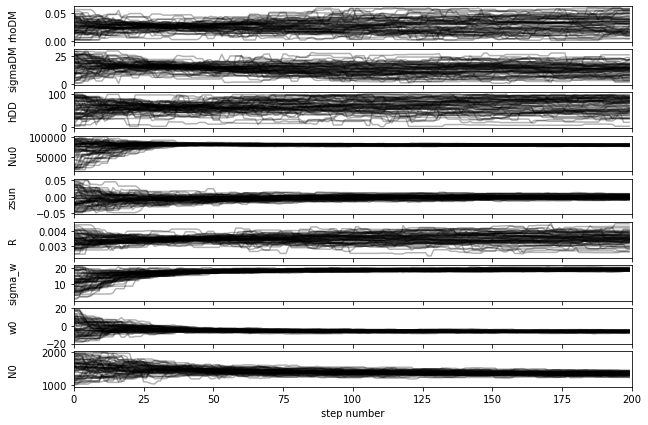

In [63]:
fig, axes = plt.subplots(9, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["rhoDM", "sigmaDM", "hDD", "Nu0", "zsun", "R", "sigma_w", "w0", "N0"]
for i in range(9):
    ax = axes[i]
    ax.plot(samples[:, :, i+24], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [64]:
import corner

flat_samples = sampler.get_chain(discard=100, flat=True)
flat_samples

array([[ 1.09986419e-02,  2.46937417e-02,  7.28215431e-03, ...,
         1.78563226e+01, -6.30650434e+00,  1.37751352e+03],
       [ 8.04847629e-03,  3.04100627e-02,  7.22326045e-03, ...,
         1.89647051e+01, -6.91313645e+00,  1.33873778e+03],
       [ 9.00600511e-03,  2.89500905e-02,  7.14328333e-03, ...,
         1.86066553e+01, -4.38658556e+00,  1.38839773e+03],
       ...,
       [ 1.17367567e-02,  2.63493151e-02,  7.45446856e-03, ...,
         1.79769990e+01, -6.95440903e+00,  1.30846520e+03],
       [ 1.27485952e-02,  2.79998036e-02,  6.12538135e-03, ...,
         1.91855707e+01, -6.82524330e+00,  1.43171074e+03],
       [ 1.28953992e-02,  2.71531790e-02,  7.36530730e-03, ...,
         1.83367473e+01, -6.08709739e+00,  1.34093615e+03]])

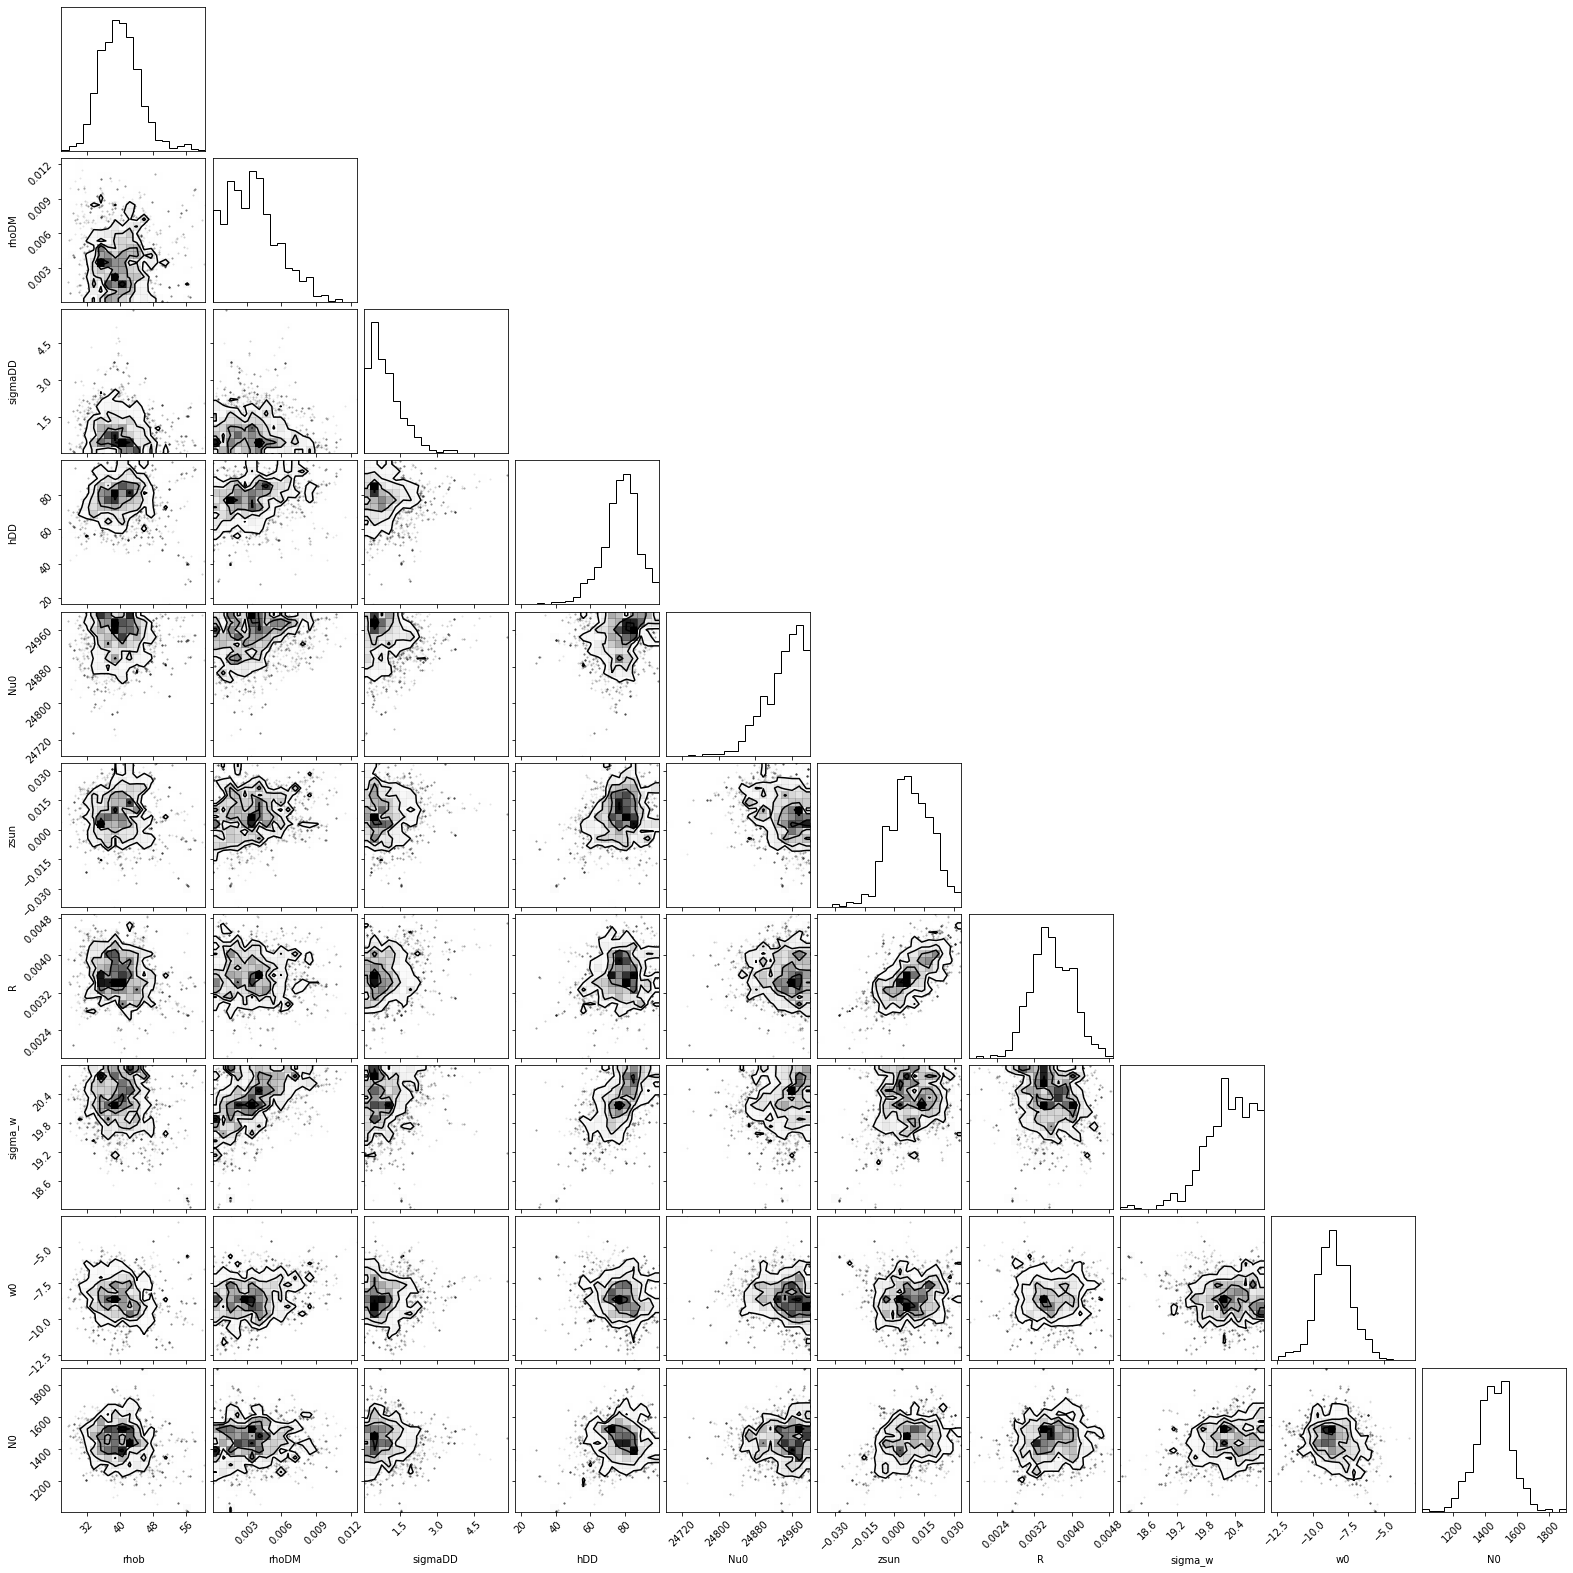

In [41]:
fig = corner.corner(
    flat_samples[:,23:], labels=["rhob", "rhoDM", "sigmaDD", "hDD", "Nu0", "zsun", "R", "sigma_w", "w0", "N0"],
)

### Compare

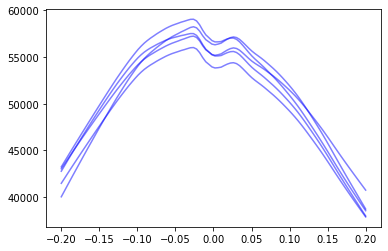

In [65]:
zz  = np.linspace(-0.2, 0.2, 100)
x = flat_samples
for i in range(5):
  index = int(np.floor(np.random.rand()*len(flat_samples)))
  theta = dict(rhos=x[index, 0:12], sigmaz=x[index, 12:24], rhoDM=x[index, 24], sigmaDD=x[index, 25], 
               hDD=x[index, 26], Nu0=x[index, 27], zsun=x[index, 28], R=x[index, 29], sigma_w=x[index, 30], 
               w0=x[index, 31], N0=x[index, 32])
  logNu = log_nu_mod(zz, theta) + np.log(comp_z(zz))

  plt.plot(zz, np.exp(logNu), alpha=0.5, c="blue")

In [66]:
integral = simps(np.exp(logNu), zz)
nu = np.exp(logNu)/integral
nu_f = interp1d(zz, nu, kind='cubic', fill_value='extrapolate')
cdf = np.cumsum(nu_f(zz))

<ErrorbarContainer object of 3 artists>

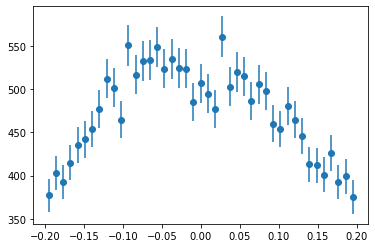

In [74]:
z_num, z_edge = np.histogram(z, bins=np.linspace(-0.2,0.2, 44))
# plt.bar((z_edge[:-1]+z_edge[1:])/2, z_num, width=np.diff(z_edge), alpha=0.5, color="red")
z_mid = (z_edge[:-1]+z_edge[1:])/2
z_err = np.sqrt(z_num)
plt.errorbar(z_mid, z_num, yerr=z_err, fmt="o")
# plt.hist(z, bins=np.linspace(-0.2,0.2, 44))